In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import os
import seaborn as sns
from varname import nameof

import tensorflow as tf
import tensorflow_probability as tfp

2025-07-22 14:02:46.913154: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 14:02:46.942110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# check if this detects GPU - this should not as the virtual env was not built on a GPU
tf.config.list_physical_devices("GPU")

[]

In [3]:
# read in the data

# path to dfs
path_to_TS_dfs = "Previous_data/all_preprocessed_data/Block_0103/TS_ready_data_frames/"

In [4]:
# list the contents here
os.listdir(path_to_TS_dfs)

['extracted_features_sub_window_0.csv']

In [5]:
# get rid of the checkpointing folder
sub_image_files = [file for file in os.listdir(path_to_TS_dfs) if file[-3:] == 'csv']

In [6]:
sub_image_files.sort() #note that this would not properly sort the df files as the names are all characters
sub_image_files

['extracted_features_sub_window_0.csv']

In [7]:
# # add the 10, 11 at the end
# im_files = ['extracted_features_sub_window_10.csv', 'extracted_features_sub_window_11.csv']

In [8]:
# other_files = [i for i in sub_image_files if i not in im_files]

In [9]:
# sub_image_files = other_files + im_files

In [10]:
# sub_image_files

In [11]:
# just get a df for a single sub image
sub_image_df_name = 'extracted_features_sub_window_0.csv'
sub_image_df_path = os.path.join(path_to_TS_dfs, sub_image_df_name)

In [12]:
sub_image_0_df = pd.read_csv(sub_image_df_path)

In [13]:
sub_image_0_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,tassel_count
0,0.000000,0.000000,0.100598,0.000000,0.079017,0.0,0.0,0.0,0.031116,0.089639,...,0.116435,0.0,0.032230,0.0,0.062460,0.078434,0.0,0.0,0.000000,3.000005
1,0.000000,0.013985,0.101657,0.000000,0.077531,0.0,0.0,0.0,0.044242,0.099687,...,0.118193,0.0,0.044611,0.0,0.076927,0.087441,0.0,0.0,0.000000,4.000000
2,0.000000,0.025038,0.087744,0.000000,0.079452,0.0,0.0,0.0,0.042732,0.099606,...,0.106012,0.0,0.037057,0.0,0.021749,0.075469,0.0,0.0,0.000000,4.000155
3,0.103946,0.147407,0.204129,0.098372,0.188013,0.0,0.0,0.0,0.160088,0.198620,...,0.243455,0.0,0.163562,0.0,0.190030,0.185727,0.0,0.0,0.059823,8.004741
4,0.017576,0.085960,0.171267,0.033650,0.147210,0.0,0.0,0.0,0.112189,0.165176,...,0.208353,0.0,0.117695,0.0,0.171195,0.155618,0.0,0.0,0.000000,4.000000


In [14]:
sub_image_0_df.shape

(20, 33)

In [15]:
# how does the sub count variation look like for this subwindow??

# we have 20 time points
range_time_points = np.arange(1,21)

tassel_counts = sub_image_0_df['tassel_count']

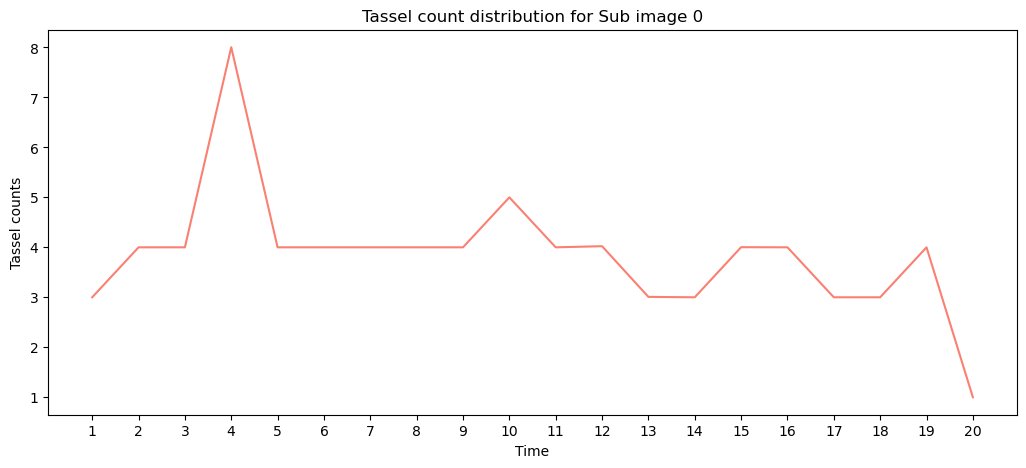

In [16]:
# look at this distribution
plt.figure(figsize = (12.5,5))
plt.plot(range_time_points, tassel_counts, color = 'salmon')
plt.xticks(range_time_points)
plt.title("Tassel count distribution for Sub image 0")
plt.xlabel("Time")
plt.ylabel("Tassel counts")
plt.show()

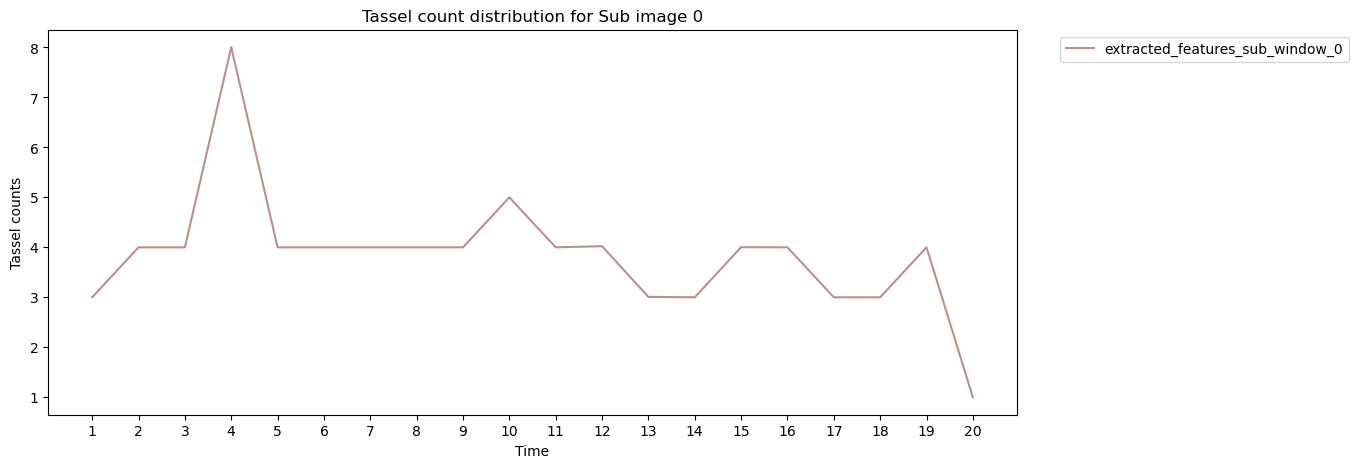

In [17]:
# Also draw a plot for all 12 subwindows on the same plot to see how the tassel count distributions look like?
colors = ['rosybrown', 'lightcoral', 'orangered', 'darkorange', 'goldenrod', 'olive', 'yellowgreen', 'lightgreen', 'forestgreen', 'darkcyan', 'dodgerblue',
         'darkorchid']
plt.figure(figsize = (12.5,5))
counter = 0
for file in sub_image_files:
    joined_path = os.path.join(path_to_TS_dfs, file)
    read_df = pd.read_csv(joined_path)
    tass_count = read_df['tassel_count']
    plt.plot(range_time_points, tass_count, color = colors[counter], label = file.split(".")[0])
    counter = counter + 1
plt.xticks(range_time_points)
plt.title("Tassel count distribution for Sub image 0")
plt.xlabel("Time")
plt.ylabel("Tassel counts")
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1), loc = 1)
plt.show()

In [18]:
# Okay, none of the plots look nice, but that's okay I guess

In [19]:
# Okay, lets now divide our data into train and test components: I'm thinking a 13-7 split (thats a 65%-35%, maybe too little data in the train split, lets change this later and stick to this for now)

In [20]:
13/20

0.65

In [21]:
forecast_steps = 7

In [22]:
train_data = sub_image_0_df.iloc[:-7, :]
test_data = sub_image_0_df.iloc[-7:, :]

In [23]:
train_data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,tassel_count
0,0.000000,0.000000,0.100598,0.000000,0.079017,0.0,0.0,0.0,0.031116,0.089639,...,0.116435,0.0,0.032230,0.0,0.062460,0.078434,0.0,0.0,0.000000,3.000005
1,0.000000,0.013985,0.101657,0.000000,0.077531,0.0,0.0,0.0,0.044242,0.099687,...,0.118193,0.0,0.044611,0.0,0.076927,0.087441,0.0,0.0,0.000000,4.000000
2,0.000000,0.025038,0.087744,0.000000,0.079452,0.0,0.0,0.0,0.042732,0.099606,...,0.106012,0.0,0.037057,0.0,0.021749,0.075469,0.0,0.0,0.000000,4.000155
3,0.103946,0.147407,0.204129,0.098372,0.188013,0.0,0.0,0.0,0.160088,0.198620,...,0.243455,0.0,0.163562,0.0,0.190030,0.185727,0.0,0.0,0.059823,8.004741
4,0.017576,0.085960,0.171267,0.033650,0.147210,0.0,0.0,0.0,0.112189,0.165176,...,0.208353,0.0,0.117695,0.0,0.171195,0.155618,0.0,0.0,0.000000,4.000000


In [24]:
train_data.shape

(13, 33)

In [25]:
test_data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,tassel_count
13,0.0,0.0,0.000000,0.0,0.000000,0.287550,0.0,0.271238,0.0,0.000000,...,0.000000,0.298749,0.0,0.329094,0.00000,0.000000,0.309945,0.287163,0.0,3.000000
14,0.0,0.0,0.000000,0.0,0.000000,0.552956,0.0,0.520200,0.0,0.000000,...,0.000000,0.579057,0.0,0.618700,0.00000,0.000000,0.598290,0.543111,0.0,4.002516
15,0.0,0.0,0.047503,0.0,0.026331,0.031699,0.0,0.027561,0.0,0.025827,...,0.054322,0.024045,0.0,0.035481,0.00755,0.034951,0.009745,0.019481,0.0,4.000155
16,0.0,0.0,0.000000,0.0,0.000000,1.270255,0.0,1.173240,0.0,0.000000,...,0.000000,1.313207,0.0,1.364042,0.00000,0.000000,1.367619,1.266345,0.0,3.000000
17,0.0,0.0,0.000000,0.0,0.000000,0.797787,0.0,0.742618,0.0,0.000000,...,0.000000,0.829753,0.0,0.874387,0.00000,0.000000,0.877240,0.804976,0.0,3.000000


In [26]:
test_data.shape

(7, 33)

In [27]:
# Okay, let's plot the data as train and test as per the chapter 6 of the Bayesian computations book

In [28]:
train_counts = train_data['tassel_count']
test_counts = test_data['tassel_count']

In [29]:
np.arange(1, train_counts.shape[0] + 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [30]:
np.arange(train_counts.shape[0] + 1, train_counts.shape[0] + 1 + test_counts.shape[0])

array([14, 15, 16, 17, 18, 19, 20])

In [31]:
def plot_tassel_count_data(train_data, test_data, df_no, fig_ax=None):
    if not fig_ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig, ax = fig_ax
    ax.plot(train_data, color = 'blue', label="training data")
    ax.plot(test_data, color = 'lightcoral', label="testing data")
    ax.legend()
    ax.set(
        ylabel="Tassel counts" ,
        xlabel="Time",
        title = "Tassel count distribution for sub image " + str(df_no)
    )
    fig.autofmt_xdate()
    fig.show()
    return fig, ax

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Tassel count distribution for sub image 0'}, xlabel='Time', ylabel='Tassel counts'>)

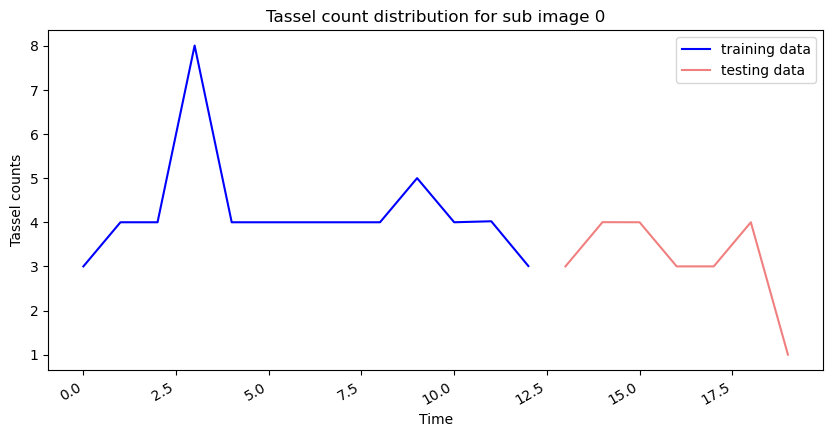

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_tassel_count_data(train_counts, test_counts, 0, (fig, ax))

In [33]:
# tfp particulars
tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

In [34]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)

In [35]:
# let's first add a column for the intercept - to add this to the beggining use insert instead of the regular way
sub_image_0_df.insert(0, 'intercept', np.repeat(1, sub_image_0_df.shape[0]))
sub_image_0_df['intercept'] = sub_image_0_df['intercept'].astype("float32")
# sub_image_0_df

In [36]:
sub_image_0_df.head()

,intercept,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,tassel_count
0,1.0,0.000000,0.000000,0.100598,0.000000,0.079017,0.0,0.0,0.0,0.031116,...,0.116435,0.0,0.032230,0.0,0.062460,0.078434,0.0,0.0,0.000000,3.000005
1,1.0,0.000000,0.013985,0.101657,0.000000,0.077531,0.0,0.0,0.0,0.044242,...,0.118193,0.0,0.044611,0.0,0.076927,0.087441,0.0,0.0,0.000000,4.000000
2,1.0,0.000000,0.025038,0.087744,0.000000,0.079452,0.0,0.0,0.0,0.042732,...,0.106012,0.0,0.037057,0.0,0.021749,0.075469,0.0,0.0,0.000000,4.000155
3,1.0,0.103946,0.147407,0.204129,0.098372,0.188013,0.0,0.0,0.0,0.160088,...,0.243455,0.0,0.163562,0.0,0.190030,0.185727,0.0,0.0,0.059823,8.004741
4,1.0,0.017576,0.085960,0.171267,0.033650,0.147210,0.0,0.0,0.0,0.112189,...,0.208353,0.0,0.117695,0.0,0.171195,0.155618,0.0,0.0,0.000000,4.000000


In [37]:
X_preds = sub_image_0_df.iloc[:, :-1]

In [38]:
X_preds.shape

(20, 33)

In [39]:
X_preds.head()

,intercept,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31
0,1.0,0.000000,0.000000,0.100598,0.000000,0.079017,0.0,0.0,0.0,0.031116,...,0.099476,0.116435,0.0,0.032230,0.0,0.062460,0.078434,0.0,0.0,0.000000
1,1.0,0.000000,0.013985,0.101657,0.000000,0.077531,0.0,0.0,0.0,0.044242,...,0.109001,0.118193,0.0,0.044611,0.0,0.076927,0.087441,0.0,0.0,0.000000
2,1.0,0.000000,0.025038,0.087744,0.000000,0.079452,0.0,0.0,0.0,0.042732,...,0.114904,0.106012,0.0,0.037057,0.0,0.021749,0.075469,0.0,0.0,0.000000
3,1.0,0.103946,0.147407,0.204129,0.098372,0.188013,0.0,0.0,0.0,0.160088,...,0.227564,0.243455,0.0,0.163562,0.0,0.190030,0.185727,0.0,0.0,0.059823
4,1.0,0.017576,0.085960,0.171267,0.033650,0.147210,0.0,0.0,0.0,0.112189,...,0.179570,0.208353,0.0,0.117695,0.0,0.171195,0.155618,0.0,0.0,0.000000


In [40]:
# This X_preds above is a dataframe, let's make it a numpy array
X_pred = X_preds.values

In [41]:
# n_preds would be the number of X variables we have which is 32 + 1 along with the intercept
n_pred = X_pred.shape[1]
n_pred

33

In [42]:
def get_prioirs_and_x_beta():
    beta = yield root(tfd.Sample(
        tfd.Normal(0., 1.),
        sample_shape=n_pred,
        name='beta'))
    x_beta = tf.einsum('ij,...j->...i', X_pred, beta)

    noise_sigma = yield root(tfd.HalfNormal(scale=2., name='noise_sigma'))

    intercept_data = sub_image_0_df['intercept']

    return x_beta, intercept_data, noise_sigma

In [43]:
# well we do need a trend variable, because the AR function has a zeros like input based on trend as the strating values.

In [44]:
# spend some time here to properly do the function to implement the mcmc procedure

In [45]:
def generate_model_ar_latent(training=True):

    @tfd.JointDistributionCoroutine
    def model_with_latent_ar():
        x_beta, intercept_data, noise_sigma = yield from get_prioirs_and_x_beta()
        
        # Latent AR(1)
        ar_sigma = yield root(tfd.HalfNormal(.1, name='ar_sigma'))
        rho = yield root(tfd.Uniform(-1., 1., name='rho'))
        def ar_fun(y):
            loc = tf.concat([tf.zeros_like(y[..., :1]), y[..., :-1]],
                            axis=-1) * rho[..., None]
            return tfd.Independent(
                tfd.Normal(loc=loc, scale=ar_sigma[..., None]),
                reinterpreted_batch_ndims=1)
        temporal_error = yield tfd.Autoregressive(
            distribution_fn=ar_fun,
            sample0=tf.zeros_like(intercept_data),
            num_steps=intercept_data.shape[-1],
            name='temporal_error')

        # Linear prediction
        y_hat = x_beta + temporal_error
        if training:
            y_hat = y_hat[..., :train_data.shape[0]]

        # Likelihood
        observed = yield tfd.Independent(
            tfd.Normal(y_hat, noise_sigma[..., None]),
            reinterpreted_batch_ndims=1,
            name='observed'
        )

    return model_with_latent_ar

In [46]:
%%time
gam_with_latent_ar = generate_model_ar_latent(training = True)

CPU times: user 323 µs, sys: 0 ns, total: 323 µs
Wall time: 334 µs


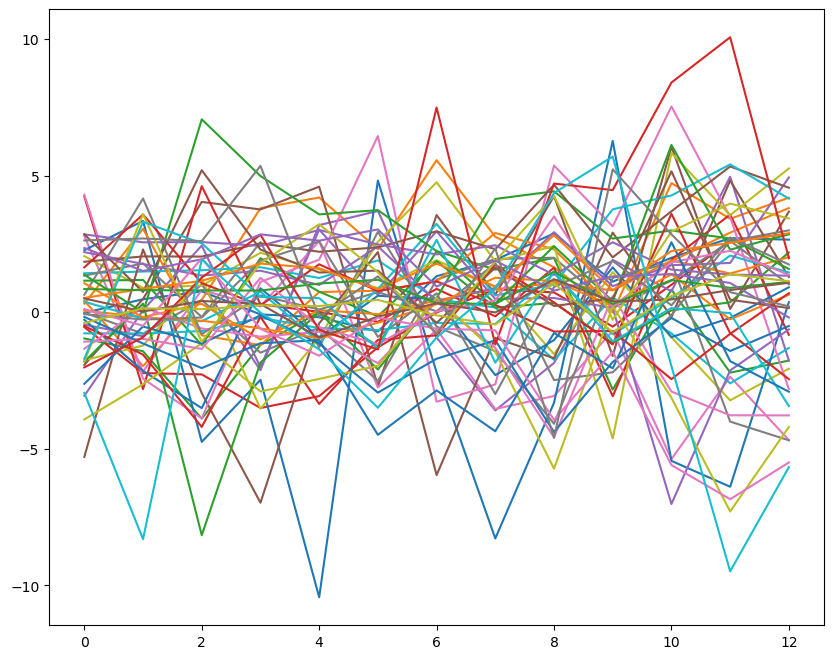

CPU times: user 1.09 s, sys: 173 ms, total: 1.26 s
Wall time: 1.08 s


In [47]:
%%time
plt.figure(figsize = (10,8))
plt.plot(tf.transpose(gam_with_latent_ar.sample(50)[-1]))
plt.show()

In [48]:
# sub_image_0_df['intercept'].astype("float32")

In [49]:
train_counts = train_counts.astype("float32")
test_counts = test_counts.astype("float32")

In [50]:
%%time
# The mcmc with nuts sample happens below
mcmc_samples_bts, sampler_stats_bts = run_mcmc(
    2000, gam_with_latent_ar, n_chains=4, num_adaptation_steps=1000,
    seed=tf.constant([65, 738], dtype=tf.int32),
    observed=train_counts.T)

2025-07-22 14:03:08.810976: I external/local_xla/xla/service/service.cc:168] XLA service 0x5582937c2150 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-07-22 14:03:08.811021: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-07-22 14:03:09.334301: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure/ldj_reduction_ndims/assert_equal_1/Assert/Assert
2025-07-22 14:03:09.343379: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure_of_jointmap_of_reshape_and_reshape_1_and_reshape_2_and_reshape_3_and_reshape_4/ldj_reduction_ndims_5/assert_equal_1/Assert/Assert
2025-07-22 14:03:09.347551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-

CPU times: user 35 s, sys: 1.43 s, total: 36.5 s
Wall time: 36.6 s


In [51]:
# sampler_stats_bts

In [52]:
gam_with_latent_ar_full_bts = generate_model_ar_latent(training=False)
posterior_dists_bts, ppc_samples_bts = gam_with_latent_ar_full_bts.sample_distributions(value=mcmc_samples_bts)

In [53]:
len(mcmc_samples_bts)

5

In [54]:
nchains = 4

CPU times: user 152 ms, sys: 27.1 ms, total: 180 ms
Wall time: 150 ms


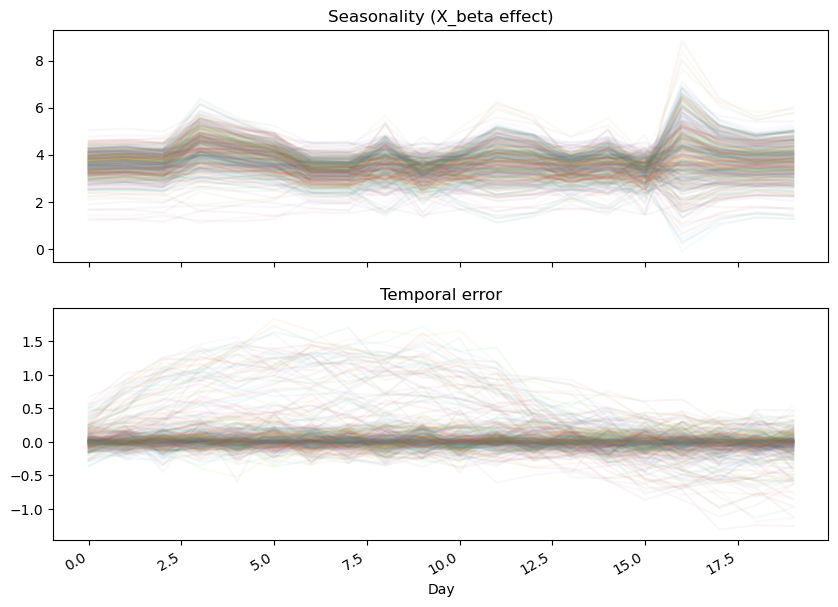

In [55]:
%%time
# plot components
fig, ax = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

beta = mcmc_samples_bts[0]
seasonality_posterior = tf.einsum('ij,...j->...i', X_pred, beta)
temporal_error = mcmc_samples_bts[-1]
# temporal_error_ = mcmc_samples[7]
# temporal_error = tf.concat([tf.zeros_like(temporal_error_[..., :1]),
#                             temporal_error_], axis=-1)

for i in range(nchains):
    ax[0].plot(np.arange(20), seasonality_posterior[-100:, i, :].numpy().T, alpha=.05);
    ax[1].plot(np.arange(20), temporal_error[-100:, i, :].numpy().T, alpha=.05);

ax[0].set_title('Seasonality (X_beta effect)')
ax[1].set_title('Temporal error')
ax[1].set_xlabel("Day")
fig.autofmt_xdate()

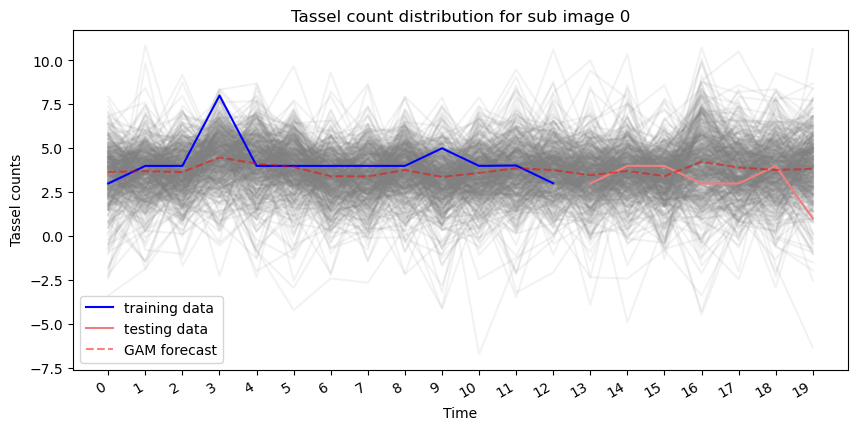

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# fitted_with_forecast = posterior_dists[-1].distribution.mean().numpy()
# fitted_with_forecast = posterior_dists[-1].distribution.sample().numpy()
fitted_with_forecast = ppc_samples_bts[-1].numpy()

ax.plot(np.arange(20), fitted_with_forecast[:250, 0, :].T, color='gray', alpha=.1);
ax.plot(np.arange(20), fitted_with_forecast[:250, 1, :].T, color='gray', alpha=.1);

plot_tassel_count_data(train_counts, test_counts, 0, (fig, ax))

average_forecast = np.mean(fitted_with_forecast, axis=(0, 1)).T
ax.plot(np.arange(20), average_forecast, ls='--', label='GAM forecast', color = 'red', alpha=.5);
plt.xticks(np.arange(20))
plt.legend()
plt.show()

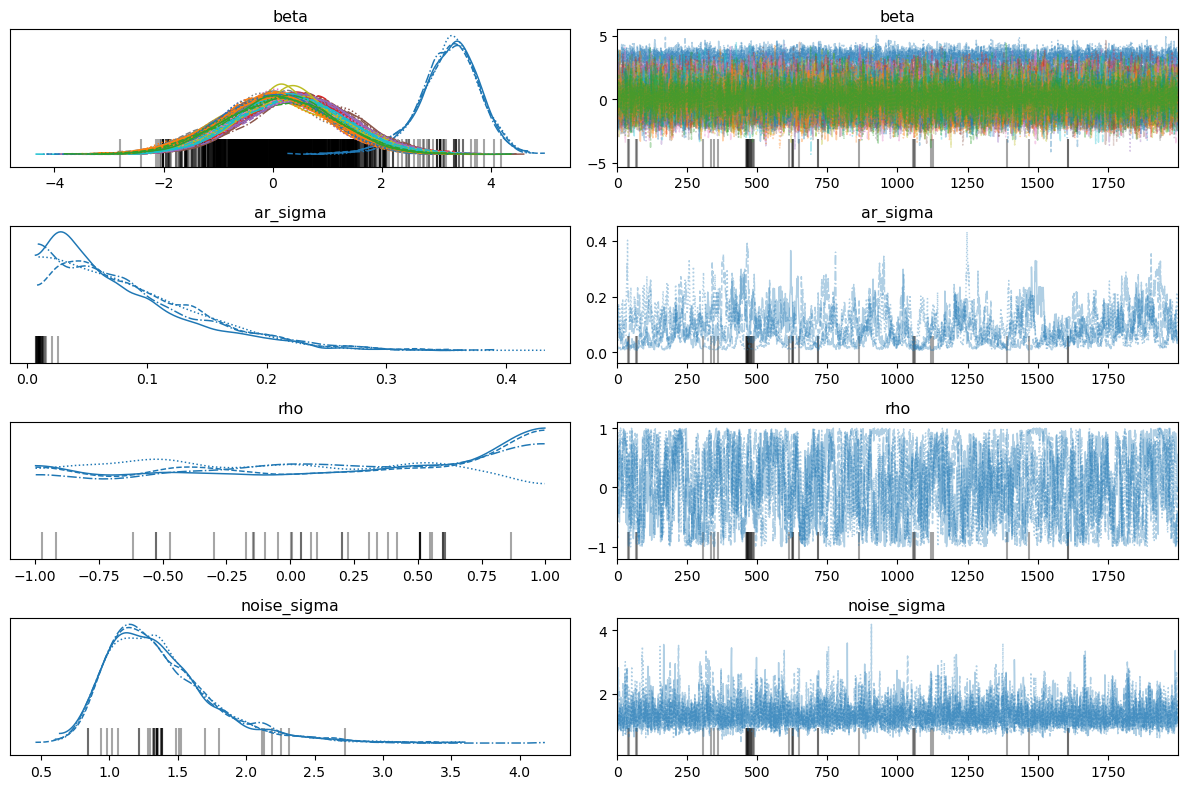

In [57]:
# Let's also get the posterior plots
nuts_trace_ar_latent = az.from_dict(
    posterior={
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples_bts._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats_bts[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

axes = az.plot_trace(
    nuts_trace_ar_latent,
    var_names=['beta', 'ar_sigma', 'rho', 'noise_sigma'],
    compact=True);

plt.tight_layout()

In [58]:
# posterior parameter summary
parameter_summary = az.summary(nuts_trace_ar_latent)

In [59]:
parameter_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar_sigma,0.086,0.061,0.008,0.198,0.005,0.003,148.0,325.0,1.01
beta[0],3.235,0.556,2.150,4.245,0.007,0.005,6331.0,4000.0,1.00
beta[1],0.212,0.997,-1.663,2.112,0.009,0.013,11488.0,4889.0,1.00
beta[2],0.313,0.999,-1.502,2.258,0.009,0.012,12647.0,5269.0,1.00
beta[3],0.380,0.982,-1.493,2.170,0.009,0.011,12635.0,6172.0,1.00
beta[4],0.205,1.003,-1.715,2.062,0.009,0.012,11947.0,5660.0,1.00
beta[5],0.337,0.979,-1.579,2.119,0.009,0.011,10951.0,5628.0,1.00
beta[6],0.076,0.982,-1.850,1.877,0.009,0.013,11894.0,5573.0,1.00
beta[7],0.000,1.008,-1.931,1.869,0.009,0.013,12017.0,5177.0,1.00
beta[8],0.056,1.014,-1.774,1.986,0.010,0.013,9996.0,2652.0,1.00


In [60]:
# how many parameters do we have?
parameter_summary.shape

(56, 9)

In [61]:
# Okay, now since the plots created above are really messy, let's recreate them properly - to make life easier later, so that we do not have to revisit and do this from scratch if we need to implement the plots.

Recreate trace plots

In [62]:
# Get the values we need to create the trace plots with - these are inside the nuts_trace_ar_latent

In [63]:
# rho
rho_values = nuts_trace_ar_latent.posterior.rho
rho_values.shape # for the 4 chains

(4, 2000)

In [64]:
# ar sigma
ar_sigma_values = nuts_trace_ar_latent.posterior.ar_sigma
ar_sigma_values.shape # for the 4 chains

(4, 2000)

In [65]:
# noise sigma
noise_sigma_values = nuts_trace_ar_latent.posterior.noise_sigma
noise_sigma_values.shape # for the 4 chains

(4, 2000)

In [66]:
# how about the betas? -  there's going to be 33 - including the intercept
beta_vals_all = nuts_trace_ar_latent.posterior.beta
beta_vals_all.shape

(4, 2000, 33)

In [67]:
# get the betas gathered and plot them all in a single plot
all_betas = []
for i in range(33):
    betas = beta_vals_all[: ,: , i]
    all_betas.append(betas)
len(all_betas)

33

In [68]:
color_list = ['cornflowerblue', 'lightsteelblue', 'blue', 'mediumblue', 'cyan', 'deepskyblue', 'steelblue', 'dodgerblue', 'lightslategray', 'mediumslateblue',
             'lightblue', 'teal', 'royalblue', 'indianred', 'deepskyblue', 'honeydew', 'lightseagreen', 'turquoise', 'cadetblue', 'tan', 'moccasin', 'burlywood',
             'peachpuff', 'powderblue', 'mediumaquamarine', 'powderblue', 'thistle', 'lavender', 'lightcyan', 'darkseagreen', 'honeydew', 'lightsteelblue', 'cadetblue']
len(color_list)

33

In [69]:
color_palletes_betas = ['Greys','Purples','Blues','Greens','Oranges','Reds','YlOrBr','YlOrRd','OrRd','PuRd','RdPu','BuPu','GnBu','PuBu','YlGnBu',
 'PuBuGn','BuGn','YlGn','Greys','Purples','Blues','Greens','Oranges','Reds','YlOrBr','YlOrRd','OrRd','PuRd','RdPu','BuPu','GnBu','PuBu', 'YlGnBu']
len(color_palletes_betas)

33

In [70]:
# define a function for this?

# for a chosen parameter - param

def get_trace_plots(ax, param, color, string_params):
    ax.plot(param.T, color = color, alpha = 0.5)
    ax.set_title("Trace plot for " + string_params, fontsize=10, fontweight="bold")

In [71]:
# Create a function for this?
def get_freq_curves(ax, param, color_palette, string_params):
    sns.kdeplot(data=param.T, fill=False, ax=ax, legend = False, palette = color_palette)
    ax.set_title("Frequency plot for " + string_params, fontsize=10, fontweight="bold")

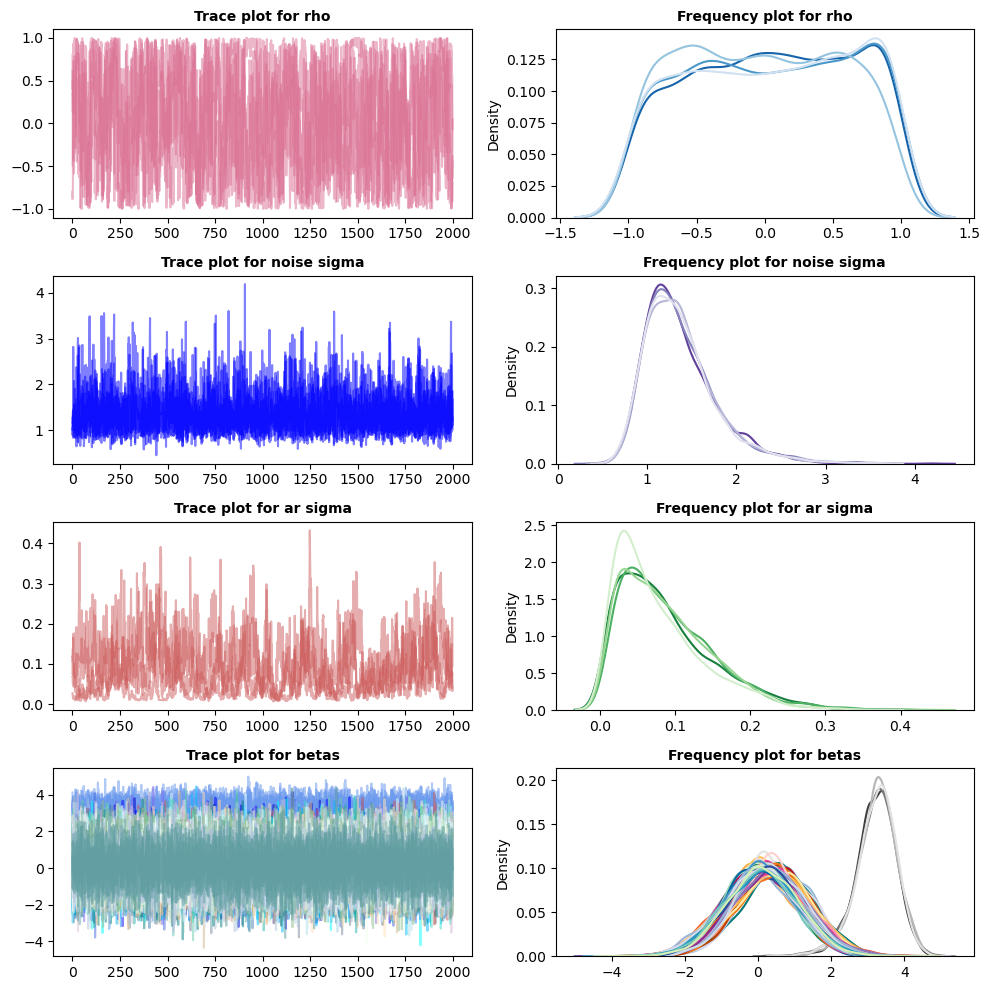

In [72]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
get_trace_plots(axs[0, 0], rho_values, 'palevioletred', 'rho')
get_trace_plots(axs[1, 0], noise_sigma_values, 'blue', 'noise sigma')
get_trace_plots(axs[2, 0], ar_sigma_values, 'indianred', 'ar sigma')
for i in range(33):
    get_trace_plots(axs[3, 0], all_betas[i], color_list[i], 'betas')
fig.tight_layout()
get_freq_curves(axs[0, 1], rho_values, 'Blues', 'rho')
get_freq_curves(axs[1, 1], noise_sigma_values, 'Purples', 'noise sigma')
get_freq_curves(axs[2, 1], ar_sigma_values, 'Greens', 'ar sigma')
for i in range(33):
    get_freq_curves(axs[3, 1], all_betas[i], color_palletes_betas[i], 'betas')
fig.tight_layout()
    # plt.plot(all_betas[i].T, color = color_list[i], alpha = 0.5)
# plt.savefig('figures/all_trace_plots.png')
plt.show()